In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## Parameters

In [2]:
class Config:
    # Data loading params
    max_sentence_length = 40
    dev_sample_percentage = 0.1
    
    # Embeddings
    embedding_dim = 300
    
    # RNN
    hidden_size = 300
    
    # Training parameters
    batch_size = 40
    num_epochs = 15
    display_every = 500
    evaluate_every = 1500
    num_checkpoints = 5
    learning_rate = 1.0
    
    # Testing parameters
    checkpoint_dir = ''

## Dataset 

Load annotated corpus for named entity recognition

https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [3]:
import nltk
import re
import os

class Dataset:
    def download_and_load_datasets(self):
        dataset = tf.keras.utils.get_file(
          fname="entity-annotated-corpus.zip", 
          origin="https://s3.ap-northeast-2.amazonaws.com/bowbowbow-storage/dataset/entity-annotated-corpus.zip", 
          extract=True)
        
        df = pd.read_csv(os.path.join(os.path.dirname(dataset), 'ner_dataset.csv'), encoding="latin1")
        return df

dataset = Dataset()
df = dataset.download_and_load_datasets()
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


### Dataset Analysis

In [4]:
print('Dataset size: ', len(df))
print('Number of unique items:', df['Sentence #'].nunique(), df.Word.nunique(), df.Tag.nunique())

Dataset size:  1048575
Number of unique items: 47959 35178 17


In [5]:
print('Tag distribution')
print(df.groupby('Tag').size().reset_index(name='count'))

Tag distribution
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


## Preprocessing

In [6]:
# fill NaN by value of preceding row
df = df.fillna(method="ffill")
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [7]:
# To remove duplicate words 
print('The number of unique words(before) :', df.Word.nunique())
df['Word'] = df['Word'].str.lower()
print('The number of unique words(after) :', df.Word.nunique())

The number of unique words(before) : 35178
The number of unique words(after) : 31817


In [8]:
# Group by same sentence
data = []

for key, group in df.groupby('Sentence #'):
    words = []
    for w, t in zip(group['Word'].values.tolist(), group['Tag'].values.tolist()):
        words.append((w,t))
    data.append(words)

data[:1]

[[('thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('london', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('british', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')]]

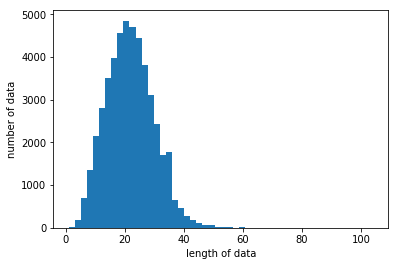

In [9]:
# Length distribution
# This gives insight to determine the maximum sentence length.
plt.hist([len(s) for s in data], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [10]:
word_list = list(set(df['Word'].values.tolist() )) + ['<PAD>', '<UNK>']
word2idx = {w: i for i, w in enumerate(word_list)}
idx2word = {i: w for i, w in enumerate(word_list)}

tag_list = list(set(df['Tag'].values.tolist()))
tag2idx = {w: i for i, w in enumerate(tag_list)}
idx2tag = {i: w for i, w in enumerate(tag_list)}

x, lengths, y = [], [], []
for sentence in tqdm(data):
    sentence = sentence[:Config.max_sentence_length]
    lengths.append(Config.max_sentence_length)
    if len(sentence) < Config.max_sentence_length:
        lengths[-1] = len(sentence)
        sentence += [('<PAD>', 'O')] * (Config.max_sentence_length - len(sentence))
    
    x_row, y_row = [], []
    for word, tag in sentence:
        x_row.append(word2idx[word])
        y_row.append(tag2idx[tag])
    
    x.append(x_row)
    y.append(y_row)

100%|██████████| 47959/47959 [00:00<00:00, 73637.13it/s]


In [11]:
x = np.array(x)
y = np.array(y)
lengths = np.array(lengths)

# Randomly shuffle data to split into train and dev
np.random.seed(11)
shuffle_indices = np.random.permutation(np.arange(len(y)))

x_shuffled, lengths_shuffled, y_shuffled = x[shuffle_indices], lengths[shuffle_indices], y[shuffle_indices]

# Split train/dev set
dev_sample_index = -1 * int(Config.dev_sample_percentage*float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:] 
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:] 
lengths_train, lengths_dev = lengths_shuffled[:dev_sample_index], lengths_shuffled[dev_sample_index:]

print("Train/Dev split: {:d}/{:d}\n".format(len(y_train), len(y_dev)))

Train/Dev split: 43164/4795



## Model

In [12]:
class Model:
    def __init__(self, 
               sequence_length, 
               num_classes, 
               vocab_size, 
               embedding_size, 
               hidden_size):
        
        self.input_x = tf.placeholder(tf.int32, shape=[None, sequence_length], name='input_x')
        self.input_y = tf.placeholder(tf.int32, shape=[None, sequence_length], name='input_y')
        self.sequence_lengths = tf.placeholder(tf.int32, shape=[None], name="sequence_lengths")
        self.dropout = tf.placeholder(dtype=tf.float32, shape=[],name="dropout")
        
        initializer = tf.contrib.layers.xavier_initializer()
        
        # Embedding layer
        with tf.device('/cpu:0'), tf.variable_scope('text-embedding'):
            self.W_text = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -0.25, 0.25), name='W_text')
            self.embedded_chars = tf.nn.embedding_lookup(self.W_text, self.input_x) # [batch_size, sequence_length, embedding_size]
            
        # Bidirectional LSTM
        with tf.variable_scope("bi-lstm"):
            fw_cell = tf.nn.rnn_cell.LSTMCell(hidden_size, initializer=initializer)
            bw_cell = tf.nn.rnn_cell.LSTMCell(hidden_size, initializer=initializer)
            (output_fw, output_bw), _ = tf.nn.bidirectional_dynamic_rnn(cell_fw=fw_cell,
                                                                  cell_bw=bw_cell,
                                                                  inputs=self.embedded_chars,
                                                                  sequence_length= self._length(self.input_x), # [batch_size],
                                                                  dtype=tf.float32)
            
            self.rnn_outputs = tf.concat([output_fw, output_bw], axis=-1)  # [batch_size, sequence_length, 2*hidden_size]
            self.rnn_outputs = tf.nn.dropout(self.rnn_outputs, self.dropout)
            
        # Fully connected layer
        with tf.variable_scope('output'):
            self.W_output = tf.get_variable('W_output', shape=[2*hidden_size, num_classes],  dtype=tf.float32, initializer=initializer)
            self.b_output = tf.get_variable('b_output', shape=[num_classes], dtype=tf.float32, initializer=tf.zeros_initializer())
            
            rnn_outputs_flat = tf.reshape(self.rnn_outputs, [-1, 2*hidden_size])
            pred = tf.matmul(rnn_outputs_flat, self.W_output) + self.b_output
            
            self.logits = tf.reshape(pred, [-1, sequence_length, num_classes]) # [batch_size, sequence_length, num_classes]
            
        # Calculate mean corss-entropy loss
        with tf.variable_scope('loss'):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.input_y)
            mask = tf.sequence_mask(self.sequence_lengths)
            losses = tf.boolean_mask(losses, mask)
            
            self.loss = tf.reduce_mean(losses) 
        
        # Accuracy    
        with tf.name_scope('accuracy'):
            self.predictions = tf.argmax(self.logits, 2, name='predictions')
            correct_predictions = tf.equal(self.predictions, tf.cast(self.input_y, tf.int64))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
    # Length of the sequence data
    @staticmethod
    def _length(seq):
        relevant = tf.sign(tf.abs(seq))
        length = tf.reduce_sum(relevant, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length

## Function for train

In [13]:
# Pre-trained glove
def load_glove(embedding_dim, word2idx):
    download_path = tf.keras.utils.get_file(
      fname="glove.6B.zip", 
      origin="http://nlp.stanford.edu/data/glove.6B.zip", 
      extract=True)
    
    embedding_path = os.path.join(os.path.dirname(download_path), 'glove.6B.300d.txt')
    print('embedding_path :', embedding_path)

    # initial matrix with random uniform
    initW = np.random.randn(len(word2idx), embedding_dim).astype(np.float32) / np.sqrt(len(word2idx))
    # load any vectors from the glove
    print("Load glove file {0}".format(embedding_path))
    f = open(embedding_path, 'r', encoding='utf8')
    for line in f:
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        if word in word2idx:
            initW[word2idx[word]] = embedding
    return initW

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data) - 1) / batch_size) + 1
    for epoch in tqdm(range(num_epochs)):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]
            
def evaluation(y, preds, lengths):
    from sklearn.metrics import classification_report
    arg_answer, arg_pred = [], []
    for i in range(len(y)):
        for j in range(lengths[i]):
            arg_answer.append(idx2tag[y[i][j]])
            arg_pred.append(idx2tag[preds[i][j]])

    print(classification_report(arg_answer, arg_pred))

## Train

In [14]:
import datetime
import time

from sklearn.metrics import f1_score
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

tf.reset_default_graph()
sess = tf.Session()
with sess.as_default():
    model = Model(
        sequence_length=x_train.shape[1],
        num_classes=len(tag_list),
        vocab_size=len(word_list),
        embedding_size=Config.embedding_dim,
        hidden_size=Config.hidden_size
    )
    
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = tf.train.AdadeltaOptimizer(Config.learning_rate).minimize(model.loss, global_step=global_step)
    
    # Output directory for models and summary
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "29.runs", timestamp))
    print("Writing to {}\n".format(out_dir))

    sess.run(tf.global_variables_initializer())

    pretrain_W = load_glove(Config.embedding_dim, word2idx)
    sess.run(model.W_text.assign(pretrain_W))
    print("Success to load pre-trained glove model!\n")
    
    # Generate batches
    batches = batch_iter(list(zip(x_train, lengths_train, y_train)), Config.batch_size, Config.num_epochs)
    
    for batch in batches:
        x_batch, lengths_train, y_batch = zip(*batch)
        
        # Train
        feed_dict = {
            model.input_x: x_batch,
            model.input_y: y_batch,
            model.sequence_lengths: lengths_train,
            model.dropout: 0.5,
        }
        _, step, loss, accuracy = sess.run(
            [train_op, global_step, model.loss, model.accuracy], feed_dict)
        
        
        # Training log display
        if step % Config.display_every == 0:
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))

        # Evaluation
        if step % Config.evaluate_every == 0:
            print("\nEvaluation:")
            feed_dict = {
                model.input_x: x_dev,
                model.input_y: y_dev,
                model.sequence_lengths: lengths_dev,
                model.dropout: 1.0,
            }
            loss, accuracy, predictions = sess.run(
                [model.loss, model.accuracy, model.predictions], feed_dict)
            
            evaluation(y_dev, predictions, lengths_dev)
            
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:.4f}\n".format(time_str, step, loss, accuracy))



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/seungwon/project/tf-notes/venv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Writing to /home/seungwon/project/tf-notes/29.runs/1558025762

embedding_path : /home/seungwon/.keras/datasets/glove.6B.300d.txt
Load glove file /home/seungwon/.keras/datasets/glove.6B.300d.txt


  0%|          | 0/15 [00:00<?, ?it/s]

Success to load pre-trained glove model!

2019-05-17T01:57:05.142881: step 500, loss 0.323016, acc 0.95
2019-05-17T01:57:22.586146: step 1000, loss 0.121825, acc 0.954375


  7%|▋         | 1/15 [00:38<08:52, 38.02s/it]

2019-05-17T01:57:40.003960: step 1500, loss 0.128909, acc 0.95875

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.00      0.00      0.00        32
       B-geo       0.76      0.85      0.80      3531
       B-gpe       0.91      0.90      0.90      1565
       B-nat       0.00      0.00      0.00        17
       B-org       0.74      0.36      0.49      2029
       B-per       0.79      0.67      0.73      1728
       B-tim       0.86      0.80      0.83      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.00      0.00      0.00        27
       I-geo       0.69      0.54      0.61       685
       I-gpe       0.00      0.00      0.00        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.64      0.39      0.49      1694
       I-per       0.77      0.86      0.81      1754
       I-tim       0.86      0.48      0.61       639
  

 13%|█▎        | 2/15 [01:16<08:17, 38.26s/it]

2019-05-17T01:58:16.052804: step 2500, loss 0.136309, acc 0.9675
2019-05-17T01:58:33.477654: step 3000, loss 0.163101, acc 0.975

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       1.00      0.03      0.06        32
       B-geo       0.81      0.86      0.83      3531
       B-gpe       0.92      0.92      0.92      1565
       B-nat       0.00      0.00      0.00        17
       B-org       0.74      0.49      0.59      2029
       B-per       0.79      0.75      0.77      1728
       B-tim       0.91      0.82      0.86      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.00      0.00      0.00        27
       I-geo       0.76      0.61      0.68       685
       I-gpe       0.00      0.00      0.00        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.69      0.47      0.56      1694
       I-per       0.83      0.86      0.84    

 20%|██        | 3/15 [01:55<07:40, 38.37s/it]

2019-05-17T01:58:51.884074: step 3500, loss 0.125756, acc 0.981875
2019-05-17T01:59:09.329256: step 4000, loss 0.0950182, acc 0.974375


 27%|██▋       | 4/15 [02:33<06:59, 38.17s/it]

2019-05-17T01:59:26.788558: step 4500, loss 0.170435, acc 0.971875

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.64      0.22      0.33        32
       B-geo       0.83      0.87      0.85      3531
       B-gpe       0.94      0.93      0.94      1565
       B-nat       0.50      0.06      0.11        17
       B-org       0.75      0.54      0.63      2029
       B-per       0.79      0.79      0.79      1728
       B-tim       0.90      0.83      0.87      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.00      0.00      0.00        27
       I-geo       0.72      0.71      0.72       685
       I-gpe       1.00      0.21      0.34        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.70      0.53      0.60      1694
       I-per       0.84      0.86      0.85      1754
       I-tim       0.87      0.63      0.73       639
 

 33%|███▎      | 5/15 [03:11<06:23, 38.35s/it]

2019-05-17T02:00:02.767606: step 5500, loss 0.093999, acc 0.97625
2019-05-17T02:00:20.263051: step 6000, loss 0.0818391, acc 0.983125

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.70      0.22      0.33        32
       B-geo       0.80      0.90      0.85      3531
       B-gpe       0.94      0.94      0.94      1565
       B-nat       0.25      0.12      0.16        17
       B-org       0.76      0.55      0.63      2029
       B-per       0.82      0.78      0.80      1728
       B-tim       0.89      0.87      0.88      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.00      0.00      0.00        27
       I-geo       0.74      0.68      0.71       685
       I-gpe       1.00      0.29      0.45        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.74      0.53      0.62      1694
       I-per       0.84      0.88      0.8

 40%|████      | 6/15 [03:50<05:46, 38.47s/it]

2019-05-17T02:00:38.735043: step 6500, loss 0.0967997, acc 0.975625
2019-05-17T02:00:56.197131: step 7000, loss 0.114105, acc 0.979375
2019-05-17T02:01:13.675680: step 7500, loss 0.0653952, acc 0.985

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.73      0.25      0.37        32
       B-geo       0.84      0.88      0.86      3531
       B-gpe       0.95      0.94      0.94      1565
       B-nat       0.33      0.06      0.10        17
       B-org       0.76      0.59      0.67      2029
       B-per       0.80      0.81      0.80      1728
       B-tim       0.92      0.85      0.88      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.00      0.00      0.00        27
       I-geo       0.73      0.75      0.74       685
       I-gpe       1.00      0.33      0.50        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.72      0

 47%|████▋     | 7/15 [04:29<05:08, 38.55s/it]

2019-05-17T02:01:32.138262: step 8000, loss 0.0463517, acc 0.9825
2019-05-17T02:01:49.608532: step 8500, loss 0.11526, acc 0.981875


 53%|█████▎    | 8/15 [05:07<04:28, 38.31s/it]

2019-05-17T02:02:07.084306: step 9000, loss 0.0655326, acc 0.983125

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.64      0.28      0.39        32
       B-geo       0.83      0.89      0.86      3531
       B-gpe       0.95      0.93      0.94      1565
       B-nat       0.25      0.06      0.10        17
       B-org       0.77      0.59      0.67      2029
       B-per       0.82      0.80      0.81      1728
       B-tim       0.91      0.86      0.88      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.43      0.22      0.29        27
       I-geo       0.73      0.78      0.76       685
       I-gpe       1.00      0.38      0.55        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.72      0.61      0.66      1694
       I-per       0.85      0.88      0.87      1754
       I-tim       0.87      0.70      0.78       639


 60%|██████    | 9/15 [05:45<03:50, 38.44s/it]

2019-05-17T02:02:43.048202: step 10000, loss 0.103522, acc 0.974375
2019-05-17T02:03:00.531931: step 10500, loss 0.15755, acc 0.96875

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.73      0.25      0.37        32
       B-geo       0.83      0.89      0.86      3531
       B-gpe       0.96      0.93      0.95      1565
       B-nat       0.33      0.24      0.28        17
       B-org       0.75      0.63      0.69      2029
       B-per       0.81      0.82      0.81      1728
       B-tim       0.90      0.87      0.88      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.40      0.07      0.12        27
       I-geo       0.76      0.75      0.76       685
       I-gpe       1.00      0.38      0.55        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.72      0.63      0.67      1694
       I-per       0.85      0.89      0.8

 67%|██████▋   | 10/15 [06:24<03:12, 38.54s/it]

2019-05-17T02:03:19.002700: step 11000, loss 0.0577571, acc 0.985625
2019-05-17T02:03:36.465624: step 11500, loss 0.0623397, acc 0.98625


 73%|███████▎  | 11/15 [07:02<02:33, 38.29s/it]

2019-05-17T02:03:53.931706: step 12000, loss 0.124934, acc 0.975

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.67      0.25      0.36        32
       B-geo       0.84      0.89      0.87      3531
       B-gpe       0.95      0.94      0.94      1565
       B-nat       0.33      0.06      0.10        17
       B-org       0.79      0.60      0.68      2029
       B-per       0.79      0.83      0.81      1728
       B-tim       0.92      0.86      0.89      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.60      0.11      0.19        27
       I-geo       0.78      0.74      0.76       685
       I-gpe       1.00      0.38      0.55        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.78      0.56      0.66      1694
       I-per       0.86      0.87      0.87      1754
       I-tim       0.91      0.66      0.76       639
   

 80%|████████  | 12/15 [07:41<01:55, 38.43s/it]

2019-05-17T02:04:29.880308: step 13000, loss 0.0531821, acc 0.981875
2019-05-17T02:04:47.365187: step 13500, loss 0.0966943, acc 0.979375

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.73      0.25      0.37        32
       B-geo       0.84      0.90      0.87      3531
       B-gpe       0.94      0.94      0.94      1565
       B-nat       0.62      0.29      0.40        17
       B-org       0.80      0.58      0.68      2029
       B-per       0.82      0.81      0.82      1728
       B-tim       0.91      0.87      0.89      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.50      0.07      0.13        27
       I-geo       0.77      0.75      0.76       685
       I-gpe       1.00      0.33      0.50        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.81      0.55      0.65      1694
       I-per       0.85      0.88     

 87%|████████▋ | 13/15 [08:19<01:17, 38.52s/it]

2019-05-17T02:05:23.289089: step 14500, loss 0.0771858, acc 0.97625
2019-05-17T02:05:40.791205: step 15000, loss 0.0899221, acc 0.98

Evaluation:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        33
       B-eve       0.62      0.25      0.36        32
       B-geo       0.85      0.89      0.87      3531
       B-gpe       0.95      0.94      0.95      1565
       B-nat       0.67      0.24      0.35        17
       B-org       0.77      0.64      0.70      2029
       B-per       0.84      0.80      0.82      1728
       B-tim       0.93      0.86      0.90      1981
       I-art       0.00      0.00      0.00        30
       I-eve       0.45      0.19      0.26        27
       I-geo       0.78      0.77      0.78       685
       I-gpe       1.00      0.46      0.63        24
       I-nat       0.00      0.00      0.00         5
       I-org       0.76      0.62      0.68      1694
       I-per       0.86      0.89      0.87

 93%|█████████▎| 14/15 [08:58<00:38, 38.60s/it]

2019-05-17T02:05:59.291469: step 15500, loss 0.0990525, acc 0.984375
2019-05-17T02:06:16.824446: step 16000, loss 0.0988977, acc 0.9825


100%|██████████| 15/15 [09:36<00:00, 38.38s/it]


## Tensorboard

```
tensorboard --logdir=./29.runs --host 0.0.0.0
```